In [1]:
import numpy as np # Para trabajar con arrays
import copy # Para copiar objetos y estructuras complejas
import torch # Core de PyTorch
import torch.nn as nn # Modulos necesarios para los modelos: (Linear, Conv2d, BatchNorm, CrossEntropyLoss, Sequential, Modulelist, y nn.Module)
import torch.nn.functional as F # Operaciones sin estado, como activaciones, pooling o perdida: (relu, softmax, cross_entropy)

from torch.utils.data import DataLoader # Manipulación de datasets
from torch.utils.data import sampler # Control de selección el indice de los datos
import torchvision.datasets as datasets # Datasets predefinidos para visión artificial
import torchvision.transforms as T # Conjunto de funciones para procesar imagenes
import torchvision.models as models # Incluye modelos pre-entrenados

import matplotlib.pyplot as plt # Ploteo para estadisticas

from sklearn import metrics # Matriz de confusion
from google.colab import files
import json

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [2]:
DATA_PATH = "/content/data" # Guardar el dataset CIFAR 10 en el almacenamiento temporal de la sesión actual

transform_resnet = T.Compose([T.Resize(224),
                             T.ToTensor(),
                             T.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])]) # Utiliza la media y desviación estándar calculadas sobre resnet para normalizar las imágenes de input

# El dataset de CIFAR10 tiene 10 clases distintas de imagenes
# 1. Avión
# 2. Automóvil
# 3. pájaro
# 4. gato
# 5. ciervo
# 6. perro
# 7. rana
# 8. caballo
# 9. barco
# 10. camión
dataset = datasets.CIFAR10(DATA_PATH,
                           train=True,
                           download=True,
                           transform=transform_resnet)

total = len(dataset)
c_entrenamiento = int(0.6 * total) # 60% de las muestras para el entrenamiento del modelo
c_validacion = int(0.2 * total) # 20% para ver que tal va
c_prueba = total - c_entrenamiento - c_validacion # 20% para pruebas
BATCH_SIZE = 64 # Cantidad de imagenes que se procesan por paso (iteración dentro de una "epoch")

g = torch.Generator().manual_seed(42)
train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                             [c_entrenamiento,
                                                              c_validacion,
                                                              c_prueba],
                                                             generator=g)

print(f"Entrenamiento: {len(train_set)}")
print(f"Validacion: {len(val_set)}")
print(f"Prueba: {len(test_set)}")

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Entrenamiento: 30000
Validacion: 10000
Prueba: 10000


In [3]:
# usan un subset del dataset y los divide en lotes de la cantidad del BATCH_SIZE
dataloaders = {"train": DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),
               "val": DataLoader(val_set, batch_size=BATCH_SIZE),
               "test": DataLoader(test_set, batch_size=BATCH_SIZE)}

In [11]:
def train(model, optimizer, scheduler, epochs, scheduler_batch=False):
    model = model.to(device=device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    phases = ["train", "val"]

    training_curves = {}
    for phase in phases:
        training_curves[phase+"_loss"] = []
        training_curves[phase+"_acc"] = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*10)

        for phase in phases:
            if phase == "train":
                model.train() # cambia el modelo a modo entrenamiento
            else:
                model.eval() # cambia el modelo a modo evaluacion

            running_loss = 0
            running_correct = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device).view(-1).long()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs) # salida del modelo
                    loss = F.cross_entropy(outputs, labels) # funcion de perdida

                    if phase == "train":
                        optimizer.zero_grad() # gradientes en cero para evitar acumulacion
                        loss.backward() # backward
                        optimizer.step() # actualizar parametros

                        if scheduler_batch and scheduler is not None:
                            scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += (outputs.argmax(1) == labels).sum().item()

            if phase == "train" and not scheduler_batch: # Only step the scheduler at the end of the epoch if not stepping per batch
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct / len(dataloaders[phase].dataset)
            training_curves[phase+"_loss"].append(epoch_loss)
            training_curves[phase+"_acc"].append(epoch_acc)

            print(f"{phase.upper():5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    print(f"\nBest val Acc: {best_acc*100:.3f}% at epoch {best_epoch+1}")

    return model, training_curves

def get_predictions_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device).view(-1).long()

            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def evaluate_split(model, dataloader, criterion=None):
    preds, labels = get_predictions_labels(model, dataloader)

    if criterion:
        running_loss = 0
        total = len(labels)
        for inputs, lbls in dataloader:
            inputs = inputs.to(device, dtype=torch.float32)
            lbls = lbls.to(device).view(-1).long()
            outputs = model(inputs)
            loss = criterion(outputs, lbls)
            running_loss += loss.item() * lbls.size(0)
        avg_loss = running_loss / total
    else:
        avg_loss = 0.0

    acc = (preds == labels).mean()
    print(f"TEST  Accuracy: {acc:.4f}")

In [5]:
def plot_training_curves(training_curves):
    plt.figure()
    plt.plot(training_curves["train_loss"], label="train")
    plt.plot(training_curves["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training curves - loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy(training_curves):
    plt.figure()
    plt.plot(training_curves["train_acc"], label="train")
    plt.plot(training_curves["val_acc"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training curves - accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, dataloader):
    preds, labels = get_predictions_labels(model, dataloader)
    class_labels = dataloader.dataset.dataset.classes

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.tick_params(axis='x', labelsize=9)
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Modelo sin transfer learning (MLP)


Epoch 1/10
----------
TRAIN Loss: 1.9078 Acc: 0.3626
VAL   Loss: 2.0499 Acc: 0.3719

Epoch 2/10
----------
TRAIN Loss: 2.0202 Acc: 0.3639
VAL   Loss: 1.8100 Acc: 0.3776

Epoch 3/10
----------
TRAIN Loss: 1.6732 Acc: 0.4156
VAL   Loss: 1.6869 Acc: 0.4013

Epoch 4/10
----------
TRAIN Loss: 1.5342 Acc: 0.4607
VAL   Loss: 1.6044 Acc: 0.4343

Epoch 5/10
----------
TRAIN Loss: 1.4293 Acc: 0.4867
VAL   Loss: 1.5787 Acc: 0.4505

Epoch 6/10
----------
TRAIN Loss: 1.3322 Acc: 0.5285
VAL   Loss: 1.5422 Acc: 0.4660

Epoch 7/10
----------
TRAIN Loss: 1.2012 Acc: 0.5719
VAL   Loss: 1.5582 Acc: 0.4748

Epoch 8/10
----------
TRAIN Loss: 1.0558 Acc: 0.6227
VAL   Loss: 1.5304 Acc: 0.4890

Epoch 9/10
----------
TRAIN Loss: 0.9013 Acc: 0.6844
VAL   Loss: 1.5346 Acc: 0.4996

Epoch 10/10
----------
TRAIN Loss: 0.8033 Acc: 0.7268
VAL   Loss: 1.5413 Acc: 0.5014

Best val Acc: 50.140% at epoch 10
TEST  Accuracy: 0.5109


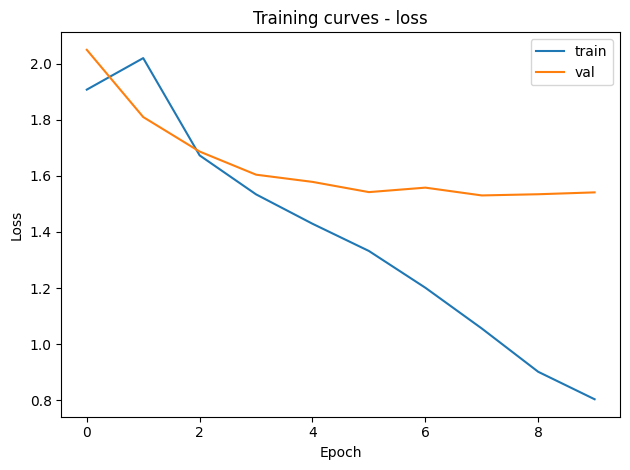

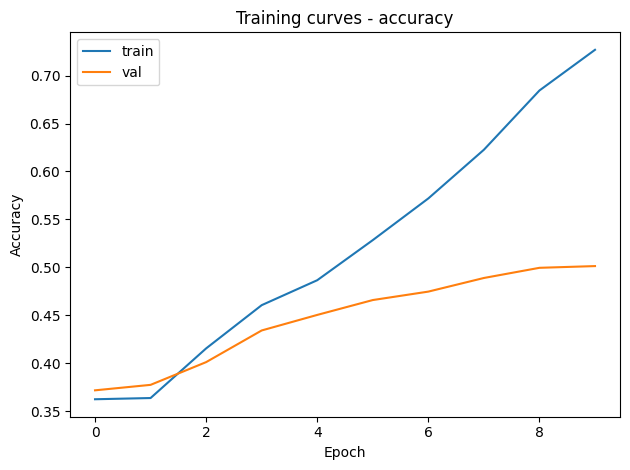

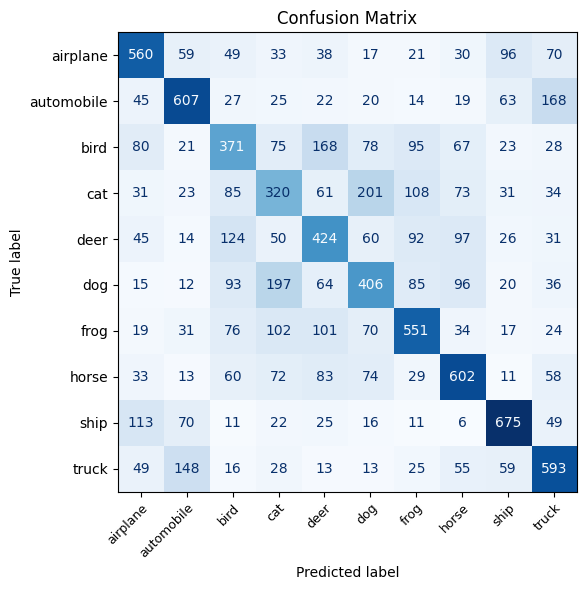

In [12]:
hidden1 = 256
hidden2 = 256
lr = 5e-4
epochs = 10

model = nn.Sequential(nn.Flatten(),
                      nn.Linear(in_features=3*224*224, out_features=hidden1),
                      nn.ReLU(),
                      nn.Linear(in_features=hidden1, out_features=hidden2),
                      nn.ReLU(),
                      nn.Linear(in_features=hidden2, out_features=10))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(dataloaders["train"]), epochs=epochs)

model, training_curves = train(model, optimizer, scheduler, epochs, scheduler_batch=True)
evaluate_split(model, dataloaders["test"])

plot_training_curves(training_curves)
plot_accuracy(training_curves)
plot_confusion_matrix(model, dataloaders["test"])

Modelo con transfer learning

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
----------
TRAIN Loss: 2.1415 Acc: 0.2500
VAL   Loss: 1.6149 Acc: 0.5485

Epoch 2/10
----------
TRAIN Loss: 1.1950 Acc: 0.6745
VAL   Loss: 0.8787 Acc: 0.7409

Epoch 3/10
----------
TRAIN Loss: 0.7907 Acc: 0.7550
VAL   Loss: 0.6992 Acc: 0.7745

Epoch 4/10
----------
TRAIN Loss: 0.6826 Acc: 0.7749
VAL   Loss: 0.6377 Acc: 0.7874

Epoch 5/10
----------
TRAIN Loss: 0.6358 Acc: 0.7870
VAL   Loss: 0.6071 Acc: 0.7935

Epoch 6/10
----------
TRAIN Loss: 0.6109 Acc: 0.7938
VAL   Loss: 0.5929 Acc: 0.8014

Epoch 7/10
----------
TRAIN Loss: 0.5973 Acc: 0.7976
VAL   Loss: 0.5899 Acc: 0.8005

Epoch 8/10
----------
TRAIN Loss: 0.5869 Acc: 0.8007
VAL   Loss: 0.5851 Acc: 0.8000

Epoch 9/10
----------
TRAIN Loss: 0.5804 Acc: 0.8033
VAL   Loss: 0.5836 Acc: 0.7999

Epoch 10/10
----------
TRAIN Loss: 0.5797 Acc: 0.8037
VAL   Loss: 0.5809 Acc: 0.8017

Best val Acc: 80.170% at epoch 10
TEST  Accuracy: 0.8034


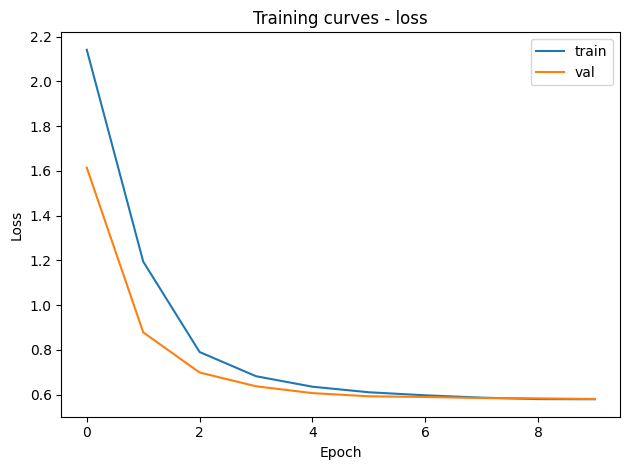

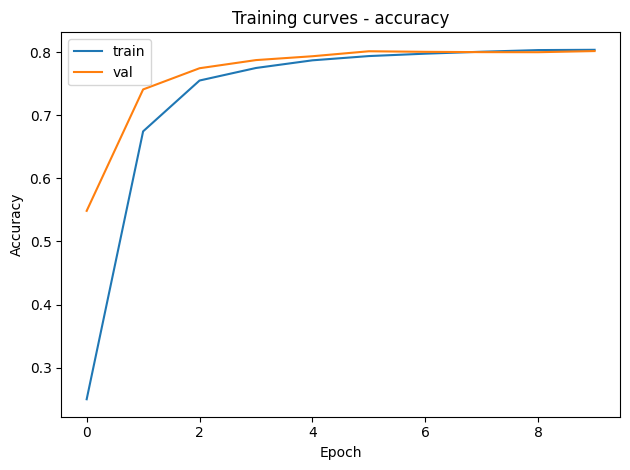

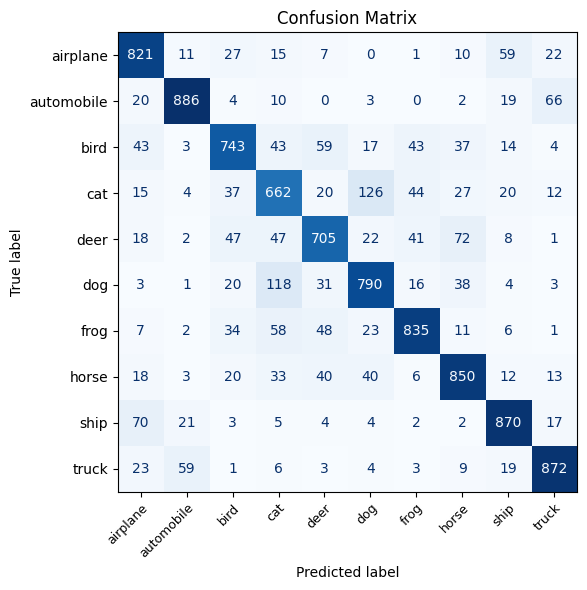

In [13]:
model_resnet18 = models.resnet18(pretrained=True)
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

for p in model_aux.parameters():
    p.requires_grad = False

last_linear = nn.Linear(in_features=512, out_features=10, bias=True)

model_transfer_learning = nn.Sequential(model_aux,
                                        nn.Flatten(),
                                        last_linear)

optimizer_transfer_learning = torch.optim.Adam(model_transfer_learning.parameters(), lr=lr)
scheduler_transfer_learning = torch.optim.lr_scheduler.OneCycleLR(optimizer_transfer_learning, max_lr=lr, steps_per_epoch=len(dataloaders["train"]), epochs=epochs)

model_transfer_learning, training_curves_transfer_learning = train(model_transfer_learning, optimizer_transfer_learning, scheduler_transfer_learning, epochs, scheduler_batch=True)
evaluate_split(model_transfer_learning, dataloaders["test"])

plot_training_curves(training_curves_transfer_learning)
plot_accuracy(training_curves_transfer_learning)
plot_confusion_matrix(model_transfer_learning, dataloaders["test"])

Modelo con transfer learning + fine-tuning


Epoch 1/10
----------
TRAIN Loss: 0.5371 Acc: 0.8170
VAL   Loss: 0.4769 Acc: 0.8395

Epoch 2/10
----------
TRAIN Loss: 0.3908 Acc: 0.8665
VAL   Loss: 0.3715 Acc: 0.8715

Epoch 3/10
----------
TRAIN Loss: 0.2285 Acc: 0.9227
VAL   Loss: 0.3306 Acc: 0.8890

Epoch 4/10
----------
TRAIN Loss: 0.0899 Acc: 0.9756
VAL   Loss: 0.3398 Acc: 0.8925

Epoch 5/10
----------
TRAIN Loss: 0.0349 Acc: 0.9941
VAL   Loss: 0.3495 Acc: 0.8942

Epoch 6/10
----------
TRAIN Loss: 0.0164 Acc: 0.9979
VAL   Loss: 0.3511 Acc: 0.8967

Epoch 7/10
----------
TRAIN Loss: 0.0089 Acc: 0.9996
VAL   Loss: 0.3620 Acc: 0.8978

Epoch 8/10
----------
TRAIN Loss: 0.0067 Acc: 0.9998
VAL   Loss: 0.3592 Acc: 0.8982

Epoch 9/10
----------
TRAIN Loss: 0.0052 Acc: 0.9999
VAL   Loss: 0.3630 Acc: 0.8988

Epoch 10/10
----------
TRAIN Loss: 0.0050 Acc: 0.9998
VAL   Loss: 0.3609 Acc: 0.8998

Best val Acc: 89.980% at epoch 10
TEST  Accuracy: 0.9048


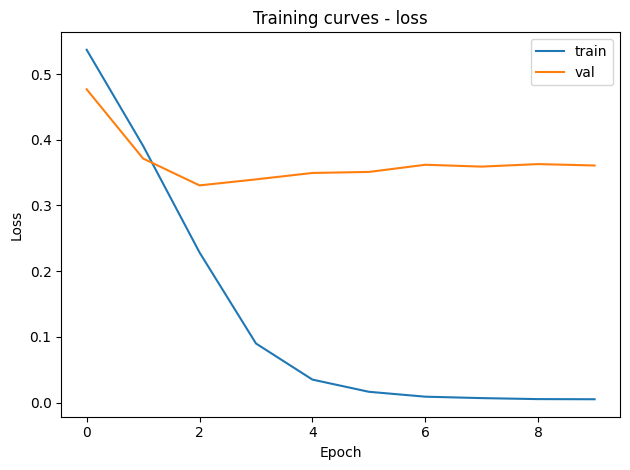

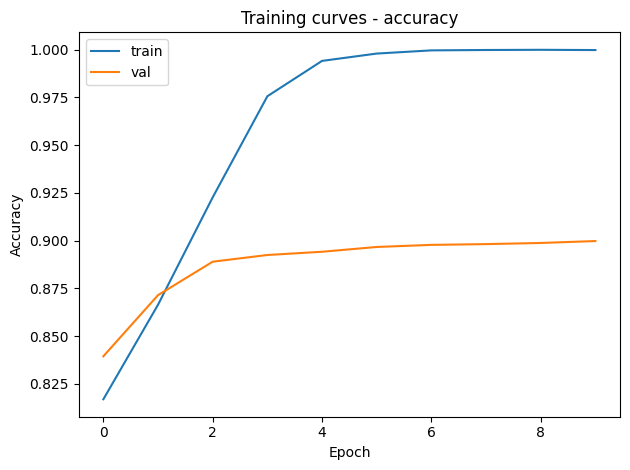

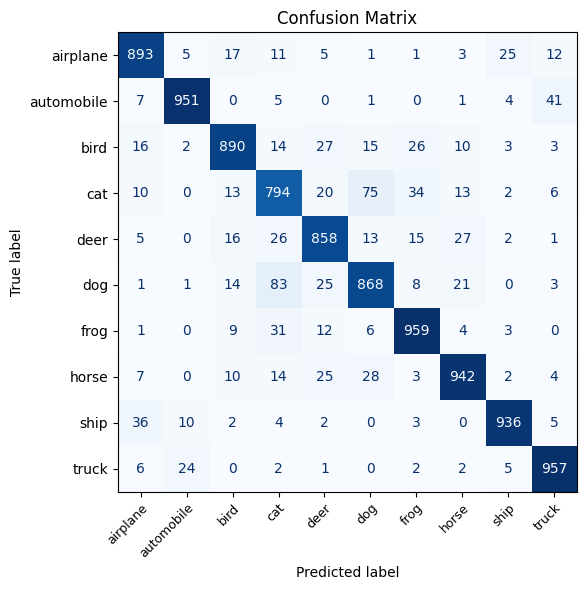

In [14]:
for p in model_resnet18.layer4.parameters():
  p.requires_grad = True

weight_decay = 1e-4

optimizer_fine_tuning = torch.optim.Adam([{'params': last_linear.parameters(), 'lr': lr, 'weight_decay': weight_decay},
                                          {'params': model_resnet18.layer4.parameters(), 'lr': lr*0.1, 'weight_decay': weight_decay}])

scheduler_fine_tuning = torch.optim.lr_scheduler.OneCycleLR(optimizer_fine_tuning,
                                                            max_lr=[lr, lr*0.1],
                                                            steps_per_epoch=len(dataloaders["train"]),
                                                            epochs=epochs)

model_fine_tuning, training_curves_fine_tuning = train(model_transfer_learning, optimizer_fine_tuning, scheduler_fine_tuning, epochs, scheduler_batch=True)
evaluate_split(model_fine_tuning, dataloaders["test"])

plot_training_curves(training_curves_fine_tuning)
plot_accuracy(training_curves_fine_tuning)
plot_confusion_matrix(model_fine_tuning, dataloaders["test"])

In [16]:
torch.save(model_fine_tuning.state_dict(), "model_state.pt")
model_fine_tuning.eval()
IMG_SIZE = 224
example_inputs = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
traced = torch.jit.trace(model_fine_tuning.to(device), example_inputs)
traced.save("model.pt")

class_names = dataset.classes
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)

preprocess = {
    "resize": [IMG_SIZE, IMG_SIZE],
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std":  [0.229, 0.224, 0.225]
}
with open("preprocess.json", "w") as f:
    json.dump(preprocess, f, indent=2)

files.download("model_state.pt")
files.download("model.pt")
files.download("class_names.json")
files.download("preprocess.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>